# Expressive Guitar Technique classifier
Ph.D. research project of [Domenico Stefani](work.domenicostefani.com)  
This notebook loads a dataset of feature vectors extracted from **pitched** and **percussive** sounds recorded with many acoustic guitars.
The techniques/classes recorded are:  

0.    **Kick**      (Palm on lower body)
1.    **Snare 1**   (All fingers on lower side)
2.    **Tom**       (Thumb on higher body)
3.    **Snare 2**   (Fingers on the muted strings, over the end
of the fingerboard)
___
4.    **Natural Harmonics** (Stop strings from playing the dominant frequency, letting harmonics ring)
5.    **Palm Mute** (Muting partially the strings with the palm
of the pick hand)
6.    **Pick Near Bridge** (Playing toward the bridge/saddle)
7.    **Pick Over the Soundhole** (Playing over the sound hole)


## Import modules and mount drive folder

In [1]:
SUPERLONG_WINDOW = True

if SUPERLONG_WINDOW:
    DATASET_FILENAME = 'onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221206-165551_SUPERLONGdataset-phase3PROCESSED_FEATURES.pickle'
else:
    DATASET_FILENAME = 'onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221201-182312_REALTIMEdataset-phase3PROCESSED_FEATURES.pickle'


In [2]:
# Choose ClassificationTask task
from enum import Enum
class ClassificationTask(Enum):
    FULL_8_CLASS_PROBLEM,BINARY_PERCUSSIVE_PITCHED,PERCUSSIVE_4_ONLY,PITCHED_4_ONLY,PERCUSSIVE_PLUS_PITCHED_CLASS = ((1,'full'), (2,'binary'), (3,'perc'), (4,'pitch'), (5,'perc+pitch'))
class FeatureSelection(Enum):
    MANUAL_VARIABLES,MANUAL_LIST,AUTO_ANOVA,AUTO_RELIEF = (1, 2, 3, 4)

In [3]:
classification_task = ClassificationTask.FULL_8_CLASS_PROBLEM
# classification_task = ClassificationTask.BINARY_PERCUSSIVE_PITCHED
# classification_task = ClassificationTask.PERCUSSIVE_4_ONLY
# classification_task = ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS

# FEATURE_SELECTION = FeatureSelection.MANUAL_VARIABLES
# FEATURE_SELECTION = FeatureSelection.MANUAL_LIST
FEATURE_SELECTION = FeatureSelection.AUTO_ANOVA #ANOVA: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
# FEATURE_SELECTION = FeatureSelection.AUTO_RELIEF

In [4]:
# Install module for the ReliefF feature selection
# !pip install skrebate
# !pip install tensorboard
# !pip3 install pickle5
# !pip3 install tensorflow==2.4.1
# !pip3 install tensorboard

In [5]:
REQUIRE_GPU = False
DO_SAVE_TENSORBOARD_LOGS = False 
DO_SAVE_FOLD_MODELS = False 
CUSTOM_PLAYER_K_FOLD = True         # Very important, this ditches the k-fold stratified random shuffle, and creates as many splits as the guitar players, separating natural groups
DROP_EXTRA_PERCUSSIVE_SOUNDS = False # If true, drop the data from files that have 'extra' in the filename, which otherwise make the dataset unbalanced


USE_TENSORBOARD = True

USE_AUGMENTED_DATA = False
DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG = False

DO_NORMALIZE_DATA = True

DO_NORMALIZE_FOR_FEATURE_SELECTION = True

# Load the TensorBoard notebook extension
if USE_TENSORBOARD:
    %load_ext tensorboard

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from sys import executable as sys_executable
from sys import argv as sys_argv
import pandas as pd
import numpy as np
import tensorflow as tf
from time import strftime, time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from bz2 import BZ2File # To open compressed data
import re
import shutil
import imblearn
from sklearn.metrics import confusion_matrix as sk_conf_matrix
from sklearn.metrics import classification_report as sk_class_report

print("Tensorflow version: " + tf.version.VERSION)
print('Imblearn version:',imblearn.__version__)

global_random_state = 42
np.random.seed(global_random_state)
tf.random.set_seed(global_random_state)

COLAB = 'google.colab' in str(get_ipython())

if COLAB:
    print('Running on CoLab')
    #Connect and mount the drive folder that contains the train dataset and the output folder
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=False)

    HOMEBASE = os.path.join('/content','gdrive','MyDrive','dottorato','Publications','02-IEEE-RTEmbeddedTimbreClassification(submitted)','Classifier')
else:
    print('Not running on CoLab')
    HOMEBASE = "./../"
DATAFOLDER = os.path.join(HOMEBASE,"data/phase3")
MODELFOLDER = os.path.join(HOMEBASE,"output")

RELIEF_CACHE_FILEPATH = os.path.join(DATAFOLDER,'relief_cache.pickle')

Tensorflow version: 2.4.1
Imblearn version: 0.6.2
Not running on CoLab


In [6]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## Enforce GPU usage

In [7]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
physical_devices = tf.config.list_physical_devices('GPU') 

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

print(physical_devices)
if REQUIRE_GPU:
  assert len(tf.config.experimental.list_physical_devices('GPU')) >= 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Check Real avaliable GRAM

In [8]:
import subprocess
import sys

def pip_install(package):
    subprocess.check_call([sys_executable, "-m", "pip", "install", package])

In [9]:
CHECK_GRAM = False

if CHECK_GRAM:
    # memory footprint support libraries/code
    os.symlink('/opt/bin/nvidia-smi','/usr/bin/nvidia-smi')
    pip_install('gputil')
    pip_install('psutil')
    pip_install('humanize')
    import psutil
    import humanize
    import os
    import GPUtil as GPU
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

# Import Dataset

In [10]:
print('Loading dataset from file:',DATASET_FILENAME)


if os.path.splitext(DATASET_FILENAME)[1] == '.bz2':
    print("Reading dataset from compressed pickle...")
    DATASET_PATH = os.path.join(DATAFOLDER,DATASET_FILENAME)
    startime = time()
    ifile = BZ2File(DATASET_PATH,'rb')
    featuredataset = pickle.load(ifile)
    ifile.close()
    print('Successfully Loaded!\nIt took %.1fs to load from compressed pickle' % (time()-startime))
elif os.path.splitext(DATASET_FILENAME)[1] == '.pickle':
    print("Reading dataset from pickle...")
    DATASET_PATH = os.path.join(DATAFOLDER,DATASET_FILENAME)
    startime = time()
    with open(DATASET_PATH,'rb') as pf:
        featuredataset = pickle.load(pf)
    print('Successfully Loaded!\nIt took %.1fs to load from regular pickle' % (time()-startime))
else:
    raise Exception("Extension %s not supported!" % os.path.splitext(DATASET_FILENAME)[1])
print('Dataset loaded!')
# display(featuredataset)

Loading dataset from file: onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221206-165551_SUPERLONGdataset-phase3PROCESSED_FEATURES.pickle
Reading dataset from pickle...
Successfully Loaded!
It took 5.3s to load from regular pickle
Dataset loaded!


In [11]:
EXPECTED_DATASED_SIZE = 23303

In [12]:
from glob import glob
augmented_featuredataset_list = []
if USE_AUGMENTED_DATA:
    augmented_data_paths = glob(os.path.join(DATAFOLDER,'augmented_data','*.pickle'))
    for augmented_data_path in augmented_data_paths:
        print("Loading file %s" % os.path.basename(augmented_data_path))
        with open(augmented_data_path,'rb') as pf:
            augmented_featuredataset_list.append(pickle.load(pf))
    augmented_featuredataset = pd.concat(augmented_featuredataset_list, ignore_index=True)
    print("Loaded %d augmented samples" % len(augmented_featuredataset))

### Drop features that we have found to be problematic with feature selection and training

In [13]:
def drop_unused_features(features_df: pd.DataFrame, inplace = False) -> pd.DataFrame:
    if not inplace:
        res_df = features_df.copy()
    else:
        res_df = features_df
    if 'attackTime_peaksamp'       not in res_df.columns.to_list() or\
       'attackTime_attackStartIdx' not in res_df.columns.to_list() or\
       'peakSample_index'          not in res_df.columns.to_list():
       raise Exception("The features dataframe does not contain the required columns!")

    res_df.drop(columns=['attackTime_peaksamp',\
                                'attackTime_attackStartIdx',\
                                'peakSample_index'], inplace=True)
    return res_df

featuredataset = drop_unused_features(featuredataset)
if USE_AUGMENTED_DATA:
    augmented_featuredataset = drop_unused_features(augmented_featuredataset)

### If specified, drop extra percussive recorded data

In [14]:
if SUPERLONG_WINDOW:
    assert featuredataset.shape[1] == 2552
else:
    assert featuredataset.shape[1] == 504

# assert featuredataset.shape == (EXPECTED_DATASED_SIZE, 504)
if DROP_EXTRA_PERCUSSIVE_SOUNDS:
    to_drop_count = np.count_nonzero(featuredataset.meta_audiofilePath.str.contains("additional-500").values)
    if to_drop_count >= 0:
        print('Dropping %d additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.'%(to_drop_count))
        featuredataset = featuredataset[~featuredataset.meta_audiofilePath.str.contains("additional-500")].reset_index(drop=True)
        print('Dataset shape after dropping extra percussive recordings: %s'%(str(featuredataset.shape)))
    # assert featuredataset.shape == (EXPECTED_DATASED_SIZE-2237, 504)


if USE_AUGMENTED_DATA and DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG:
    augmented_featuredataset_dr = augmented_featuredataset.copy()
    to_drop_count_aug = np.count_nonzero(augmented_featuredataset.meta_augmentation_source.str.contains("additional-500").values)
    if to_drop_count_aug >= 0:
        print('Dropping %d additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.'%(to_drop_count_aug))
        augmented_featuredataset_dr = augmented_featuredataset[~augmented_featuredataset.meta_augmentation_source.str.contains("additional-500")].reset_index(drop=True)
        print('Dataset shape after dropping extra percussive recordings: %s'%(str(augmented_featuredataset_dr.shape)))



In [15]:
# Extract separate DFs
from typing import Tuple

# Divide dataset into metadata, features and labels
def divide_dataset(features_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    metadata = features_df.filter(regex='^meta_',axis=1)
    labels = features_df.meta_expressive_technique_id
    features = features_df.loc[:,[col for col in features_df.columns if col not in metadata.columns]]
    # Convert to numeric formats where possible (somehow convert_dtypes doesn't work [https://stackoverflow.com/questions/65915048/pandas-convert-dtypes-not-working-on-numbers-marked-as-objects])
    metadata = metadata.apply(pd.to_numeric, errors='ignore')
    labels = labels.apply(pd.to_numeric, errors='ignore')
    features = features.apply(pd.to_numeric, errors='ignore')
    return metadata, features, labels

metadata, features, labels = divide_dataset(featuredataset)
assert metadata.shape[1] == 9
if SUPERLONG_WINDOW:
    assert features.shape[1] == 2552-9
else:
    assert features.shape[1] == 495

if USE_AUGMENTED_DATA:
    metadata_aug, features_aug, labels_aug = divide_dataset(augmented_featuredataset_dr)

In [16]:
def get_classes_description(classftask: ClassificationTask):
    if classification_task == ClassificationTask.FULL_8_CLASS_PROBLEM:
        classes_desk = {0:"Kick",1:"Snare 1",2:"Tom",3:"Snare 2",4:"Natural Harmonics",5:"Palm Mute",6:"Pick Near Bridge",7:"Pick Over the Soundhole"}
    elif classification_task == ClassificationTask.BINARY_PERCUSSIVE_PITCHED:
        classes_desk = {0:"Percussive",1:"Pitched"}
    elif classification_task == ClassificationTask.PERCUSSIVE_4_ONLY:
        classes_desk = {0:"Kick", 1:"Snare 1", 2:"Tom", 3:"Snare 2"}
    elif classification_task == ClassificationTask.PITCHED_4_ONLY:
        classes_desk = {0:"Natural Harmonics", 1:"Palm Mute", 2:"Pick Near Bridge", 3:"Pick Over the Soundhole"}
    elif classification_task == ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS:
        classes_desk = {0:"Kick", 1:"Snare 1", 2:"Tom", 3:"Snare 2", 4:"Pitched"}
    else:
        raise Exception('The Classification Task selected is not supported')
    classes = list(classes_desk.keys())
    return classes,classes_desk

def filter_dataset(tofilt_features,tofilt_labels,tofilt_metadata,classftask: ClassificationTask, hardcoded_sizes_test = False):
    if classification_task == ClassificationTask.FULL_8_CLASS_PROBLEM:
        pass
    elif classification_task == ClassificationTask.BINARY_PERCUSSIVE_PITCHED:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        tofilt_labels = tofilt_labels.replace([0,1,2,3],[0,0,0,0])
        tofilt_labels = tofilt_labels.replace([4,5,6,7],[1,1,1,1])
    elif classification_task == ClassificationTask.PERCUSSIVE_4_ONLY:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        filtered_idxs = tofilt_labels < 4
        tofilt_features = tofilt_features[filtered_idxs]
        tofilt_labels = tofilt_labels[filtered_idxs]
        tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == 1620
    elif classification_task == ClassificationTask.PITCHED_4_ONLY:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237, 'The size of the dataset is not the expected one (%d instead of %d)'%(len(tofilt_features),EXPECTED_DATASED_SIZE-2237)
        filtered_idxs = tofilt_labels >= 4
        tofilt_features = tofilt_features[filtered_idxs]
        tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        tofilt_labels = tofilt_labels[filtered_idxs]
        tofilt_labels = tofilt_labels.replace([4,5,6,7],[0,1,2,3])
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237-1620
    elif classification_task == ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS:
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        tofilt_labels = tofilt_labels.replace([5,6,7],[4,4,4])
    else:
        raise Exception('The Classification Task selected is not supported')


    tofilt_features.reset_index(drop=True,inplace=True)
    tofilt_labels.reset_index(drop=True,inplace=True)
    tofilt_metadata.reset_index(drop=True,inplace=True)

    return tofilt_features, tofilt_labels, tofilt_metadata

original_dataset_features = features.copy()
dataset_labels = labels.copy()
dataset_metadata = metadata.copy()

CLASSES,CLASSES_DESC = get_classes_description(classification_task)
original_dataset_features,dataset_labels,dataset_metadata = filter_dataset(original_dataset_features,dataset_labels,dataset_metadata,classification_task,hardcoded_sizes_test=False)
if USE_AUGMENTED_DATA:
    features_aug,labels_aug,metadata_aug = filter_dataset(features_aug,labels_aug,metadata_aug,classification_task,hardcoded_sizes_test=False)
    assert len(np.sort(CLASSES)) == len(np.sort(pd.unique(labels_aug))) and np.equal(np.sort(CLASSES),np.sort(pd.unique(labels_aug))).all()

assert len(np.sort(CLASSES)) == len(np.sort(pd.unique(dataset_labels))) and np.equal(np.sort(CLASSES),np.sort(pd.unique(dataset_labels))).all()

In [17]:
if USE_AUGMENTED_DATA:
    for dat,name in [(original_dataset_features,'Main datase'),(features_aug,'Augmented data')]:
        print('Dataset "'+name+'" read')
        print("| Entries: "+str(dat.shape[0]))
        print("╰─ Features: "+str(dat.shape[1]))

original_feature_number = original_dataset_features.shape[1]

In [18]:
# Compute has of the dataset files.
# This are used to cache precomputed feature selection with ReliefF (Which is rather slow)
import hashlib
 
dataset_sha256_hash = hashlib.sha256()
with open(DATASET_PATH,"rb") as fy:
    for byte_block in iter(lambda: fy.read(4096),b""):    # Read and update hash string value in blocks of 4K
        dataset_sha256_hash.update(byte_block)
dataset_sha256_hash = dataset_sha256_hash.hexdigest()

print(dataset_sha256_hash)

52c26922cb53a3de0742707cc9c169c9039d436748afc0a35af431576aaec19c


## Parse Command Line arguments

*_Important_*: If you are running this from a jupyter Notebook, change the run parameters at the end of the next cell

In [19]:
args = None
if not is_notebook() and not COLAB:
    import argparse
    parser = argparse.ArgumentParser(description='Train the expressive guitar technique classifier.')

    def featnum_type(x):
        (MIN,MAX) = (1,495) 
        x = int(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Feature number must be between {} and {}".format(MIN, MAX))
        return x
    parser.add_argument('-f', '--features',      default=80,     type=featnum_type,   help='Number of features to use for training [1-495] (default: 80)')   
    parser.add_argument('-v', '--verbose',        action='store_true', help='increase output verbosity')
    args = parser.parse_args()
    args = vars(args)
else:
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    """                               +-----------------------------------------------------------------------------------------------+                                 #
    #                                 |    CHANGE THE VALUES HERE IF RUNNING THE TRAINING FROM A JUPYTER NOTEBOOK (e.g., on Colab)    |                                 #
    #                                 + ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ +                                 #
    """ #↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓#
    args = {'features':      100, 
            'verbose':       False}
    #↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑#
    """                               + ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ +                                 #
    #                                 |    CHANGE THE VALUES HERE IF RUNNING THE TRAINING FROM A JUPYTER NOTEBOOK (e.g., on Colab)    |                                 #
    #                                 +-----------------------------------------------------------------------------------------------+                                 #
    """#----------------------------------------------------------------------------------------------------------------------------------------------------------------#

## Subset features

In [20]:
def get_manual_selected_features(data):
    print ("Subsetting features...")
    columns_to_keep = []
    # if USE_ATTACKTIME_PEAKSAMP:
    #     columns_to_keep.append("attackTime_peaksamp")
    # if USE_ATTACKTIME_ATTACKSTARTIDX:
    #     columns_to_keep.append("attackTime_attackStartIdx")
    if USE_ATTACKTIME_VALUE:
        columns_to_keep.append("attackTime_value")
    if USE_BARKSPECBRIGHTNESS:
        columns_to_keep.append("barkSpecBrightness")
    if USE_PEAKSAMPLE_VALUE:
        columns_to_keep.append("peakSample_value")
    # if USE_PEAKSAMPLE_INDEX:
    #     columns_to_keep.append("peakSample_index")
    if USE_ZEROCROSSING:
        columns_to_keep.append("zeroCrossing")

    assert USE_BARKSPEC <= 50 and USE_BARKSPEC >= 0 and USE_BFCC <= 49 and USE_BFCC >= 0 and USE_CEPSTRUM <= 353 and USE_CEPSTRUM >= 0 and USE_MFCC <= 37 and USE_MFCC >= 0

    if USE_BARKSPEC > 0:
        columns_to_keep += ['barkSpec_'+str(i+1) for i in range(USE_BARKSPEC)]
    if USE_BFCC > 0:
        columns_to_keep += ['bfcc_'+str(i+2) for i in range(USE_BFCC)]  # +2 is correct here since we want to skip the first normalized coefficient
    if USE_CEPSTRUM > 0:
        columns_to_keep += ['cepstrum_'+str(i+1) for i in range(USE_CEPSTRUM)]
    if USE_MFCC > 0:
        columns_to_keep += ['mfcc_'+str(i+2) for i in range(USE_MFCC)]  # +2 is correct here since we want to skip the first normalized coefficient

    return columns_to_keep

In [21]:
# # To Compeltely reset RelieFF cache
# with open(RELIEF_CACHE_FILEPATH, 'wb') as rcf:
#     pickle.dump(set(), rcf)

In [22]:
# how_many_examples_per_class =10
# subselection = list(range(0,how_many_examples_per_class))+\
#                list(range(600,600+how_many_examples_per_class))+\
#                list(range(1100,1100+how_many_examples_per_class))+\
#                list(range(1400,1400+how_many_examples_per_class))+\
#                list(range(1900,1900+how_many_examples_per_class))+\
#                list(range(3000,3000+how_many_examples_per_class))+\
#                list(range(9000,9000+how_many_examples_per_class))+\
#                list(range(14000,14000+how_many_examples_per_class))

# testprova_dataset_features = original_dataset_features.iloc[subselection]
# testprova_dataset_labels = dataset_labels.iloc[subselection]
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

class ReliefCacheElem(dict):

    PRINT_HASH = False

    def __init__(self,dataset_sha256,n_neighbors,relieff_top_features,relieff_feature_importances,time_of_computation):
        self.dataset_sha256 = dataset_sha256
        self.n_neighbors = n_neighbors
        self.relieff_top_features = relieff_top_features
        self.relieff_feature_importances = relieff_feature_importances
        self.date = strftime("%Y/%m/%d-%H:%M:%S")

        self.cpu_info = get_processor_name()
        self.time_of_computation = time_of_computation

    def __key(self):
        return tuple([self.dataset_sha256,
                     self.n_neighbors,
                     str(self.relieff_top_features),
                     str(self.relieff_feature_importances)])

    def __hash__(self):
        return hash(self.__key())

    def __str__(self):
        res = '{date: '+self.date+', n_neighbors:'+str(self.n_neighbors)
        
        if self.PRINT_HASH:
            res += 'dataset_sha256:'+str(self.dataset_sha256)+','

        res += 'cpu_info:'+str(self.cpu_info)+','
        res += 'time_of_computation:'+str(self.time_of_computation)+','
        res += '}'
        return res


def relieff_selection(X:list,y:list,n_features,n_neighbors,relief_cache_filepath,verbose_ = True):
    relief_data_X = X
    relief_data_y = y
    relief_top_features_ = None
    relief_feature_importances_ = None
    # First check if result is already cached
    ## Load Cache
    relief_cache = None

    ##----------------------------------------------##
    if not os.path.exists(relief_cache_filepath):
        raise Exception("RELIEF CACHE NOT FOUND at '"+relief_cache_filepath+"'! Comment exception to create empty cache")
        with open(relief_cache_filepath, 'wb') as rcf:
            pickle.dump(set(), rcf)
    ##----------------------------------------------##

    with open(relief_cache_filepath,'rb') as rcf:
        relief_cache = pickle.load(rcf)
        if verbose_: 
            print('Loaded Relief cache ('+str(len(relief_cache))+' solutions)')
    # Check if present
    for cache_elem in relief_cache:
        if cache_elem.dataset_sha256 == dataset_sha256_hash and\
           cache_elem.n_neighbors == n_neighbors:
            if verbose_:
                print("Result found in cache!")
            return cache_elem.relieff_top_features[:n_features]
    
    # If not present, compute
    if verbose_:
        print("Result NOT found in cache, computing now... (might take a long while)")
    
    from skrebate import ReliefF
    r = ReliefF(n_neighbors=n_neighbors,verbose=verbose_)
    
    start_fit = time()
    r.fit(X=relief_data_X,y=relief_data_y)
    top_features = r.top_features_
    feature_importances = r.feature_importances_
    stop_fit = time()

    if verbose_:
        print("Done. Now storing in cache...")

    savedata = ReliefCacheElem(
        dataset_sha256 = dataset_sha256_hash,
        n_neighbors = n_neighbors,
        relieff_top_features = top_features,
        relieff_feature_importances = feature_importances,
        time_of_computation = stop_fit - start_fit)
    relief_cache.add(savedata)
    with open(relief_cache_filepath, 'wb') as rcf:
        pickle.dump(relief_cache, rcf)

    if verbose_:
        print("Done.")


    return top_features[:n_features]

In [23]:
if FEATURE_SELECTION == FeatureSelection.AUTO_RELIEF:
    with open(RELIEF_CACHE_FILEPATH,'rb') as rcf:
        relief_cache = pickle.load(rcf)
        
        print(len(relief_cache),'cached relief runs:')

        if len(relief_cache) != 0:
            samedataset = [e for e in relief_cache if e.dataset_sha256 == dataset_sha256_hash]
            print('('+str(len(samedataset))+'/'+str(len(relief_cache)), 'are from the same dataset)')
            if len(samedataset) != len(relief_cache):
                raise Exception('Some of the cached results are from a different dataset!')

            for i,e in enumerate(relief_cache):
                print(i,':',e)

In [24]:
# ------------------------------------------------------------------------------------------------------------------------------- #

AUTO_FEATURE_NUMBER = args['features']    # If FEATURE_SELECTION is AUTO_ANOVA or AUTO_RELIEF, select this number of features automatically
# AUTO_FEATURE_NUMBER = 50
#
# ------------------------------------------------------------------------------------------------------------------------------- #

if DO_NORMALIZE_FOR_FEATURE_SELECTION:
    print('Normalizing data for feature selection...')
    feature_dataset_for_selection = original_dataset_features.to_numpy()
    from sklearn.preprocessing import StandardScaler
    feature_dataset_for_selection = StandardScaler().fit_transform(feature_dataset_for_selection)
    print('type(feature_dataset_for_selection):',type(feature_dataset_for_selection))
    # print('example row' + str(feature_dataset_for_selection[0]))
    (relief_data_X,relief_data_y) = (feature_dataset_for_selection,dataset_labels.values.ravel())
    print('Done.')
else:
    feature_dataset_for_selection = original_dataset_features.to_numpy()
    (relief_data_X,relief_data_y) = (original_dataset_features.values,dataset_labels.values.ravel())


if FEATURE_SELECTION == FeatureSelection.MANUAL_VARIABLES:
    ''' Features '''
    USE_ATTACKTIME_VALUE = True
    USE_BARKSPECBRIGHTNESS = True
    USE_PEAKSAMPLE_VALUE = True
    USE_ZEROCROSSING = False

    USE_BARKSPEC = 40 # Number in range [0-50]
    USE_BFCC = 40     # Number in range [0-50]
    USE_CEPSTRUM = 60 # Number in range [0-353]
    USE_MFCC = 30     # Number in range [0-38]

    selected_features = get_manual_selected_features(original_dataset_features)
elif FEATURE_SELECTION == FeatureSelection.MANUAL_LIST:
    selected_features = ['attackTime_value', 'barkSpecBrightness', 'barkSpec_1', 'barkSpec_2', 'barkSpec_3', 'barkSpec_4', 'barkSpec_5', 'barkSpec_6', 'barkSpec_7', 'barkSpec_8', 'barkSpec_9', 'barkSpec_10', 'barkSpec_11', 'barkSpec_12', 'barkSpec_13', 'barkSpec_14', 'barkSpec_15', 'barkSpec_16', 'barkSpec_17', 'barkSpec_18', 'barkSpec_19', 'barkSpec_20', 'barkSpec_21', 'barkSpec_22', 'barkSpec_23', 'barkSpec_24', 'barkSpec_25', 'barkSpec_26', 'barkSpec_27', 'barkSpec_28', 'barkSpec_29', 'barkSpec_30', 'barkSpec_31', 'barkSpec_32', 'barkSpec_33', 'barkSpec_34', 'barkSpec_35', 'barkSpec_36', 'barkSpec_37', 'barkSpec_38', 'barkSpec_39', 'barkSpec_40', 'barkSpec_41', 'barkSpec_42', 'barkSpec_43', 'barkSpec_44', 'barkSpec_45', 'barkSpec_46', 'barkSpec_47', 'barkSpec_48', 'barkSpec_49', 'barkSpec_50', 'bfcc_2', 'bfcc_3', 'bfcc_4', 'bfcc_5', 'bfcc_6', 'bfcc_7', 'bfcc_8', 'bfcc_9', 'bfcc_10', 'bfcc_11', 'bfcc_12', 'bfcc_13', 'bfcc_15', 'bfcc_16', 'bfcc_17', 'bfcc_18', 'bfcc_19', 'bfcc_20', 'bfcc_21', 'bfcc_25', 'bfcc_26', 'bfcc_27', 'bfcc_28', 'bfcc_29', 'bfcc_30', 'bfcc_31', 'bfcc_35', 'bfcc_36', 'bfcc_37', 'bfcc_39', 'bfcc_40', 'bfcc_42', 'bfcc_43', 'bfcc_44', 'bfcc_45', 'bfcc_46', 'bfcc_48', 'cepstrum_1', 'cepstrum_2', 'cepstrum_3', 'cepstrum_4', 'cepstrum_5', 'cepstrum_6', 'cepstrum_7', 'cepstrum_8', 'cepstrum_9', 'cepstrum_10', 'cepstrum_11', 'cepstrum_12', 'cepstrum_13', 'cepstrum_14', 'cepstrum_15', 'cepstrum_16', 'cepstrum_17', 'cepstrum_18', 'cepstrum_19', 'cepstrum_20', 'cepstrum_21', 'cepstrum_22', 'cepstrum_23', 'cepstrum_24', 'cepstrum_25', 'cepstrum_26', 'cepstrum_27', 'cepstrum_28', 'cepstrum_29', 'cepstrum_30', 'cepstrum_31', 'cepstrum_32', 'cepstrum_33', 'cepstrum_34', 'cepstrum_35', 'cepstrum_36', 'cepstrum_37', 'cepstrum_41', 'cepstrum_42', 'cepstrum_43', 'cepstrum_44', 'cepstrum_45', 'cepstrum_46', 'cepstrum_47', 'cepstrum_48', 'cepstrum_49', 'cepstrum_54', 'cepstrum_56', 'cepstrum_59', 'cepstrum_60', 'cepstrum_67', 'cepstrum_72', 'cepstrum_86', 'cepstrum_87', 'cepstrum_108', 'cepstrum_164', 'cepstrum_205', 'cepstrum_206', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23', 'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35', 'mfcc_36', 'peakSample_value', 'zeroCrossing']
elif FEATURE_SELECTION == FeatureSelection.AUTO_ANOVA:
    if original_dataset_features.shape[1] != original_feature_number:
        raise ValueError("ERROR: please import dataset again since you are trying to subset an already processed feature set ("+str(dataset_features.shape[1])+"<"+str(original_feature_number)+")")

    # ANOVA feature selection for numeric input and categorical output (https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/#:~:text=Feature%20selection%20is%20the%20process,the%20performance%20of%20the%20model)
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif
    
    fs = SelectKBest(score_func=f_classif, k=AUTO_FEATURE_NUMBER) # Define feature selection
    X_selected = fs.fit_transform(feature_dataset_for_selection, dataset_labels.to_numpy().ravel())                         # Apply feature selection
    support = fs.get_support(indices=True)                      # Extract selected indexes
    selected_features = original_dataset_features.columns[support].tolist()
    print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
elif FEATURE_SELECTION == FeatureSelection.AUTO_RELIEF:
    support = relieff_selection(relief_data_X,relief_data_y,AUTO_FEATURE_NUMBER,n_neighbors=5,relief_cache_filepath=RELIEF_CACHE_FILEPATH,verbose_= True)
    selected_features = original_dataset_features.columns[support].tolist()
    print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
    

else:
    raise Exception("ERROR! This type of feature selection is not supported")

dataset_features = original_dataset_features.copy().loc[:,selected_features]
if USE_AUGMENTED_DATA:
    features_aug = features_aug.copy().loc[:,selected_features]
print("Features reduced "+('manually' if (FEATURE_SELECTION == FeatureSelection.MANUAL_LIST or FEATURE_SELECTION == FeatureSelection.MANUAL_VARIABLES) else 'automatically')+" ("+str(FEATURE_SELECTION)+") from "+str(original_feature_number)+" to : "+str(dataset_features.shape[1]))

Normalizing data for feature selection...
type(feature_dataset_for_selection): <class 'numpy.ndarray'>
Done.
100 best features:['barkSpecBrightness', 'barkSpec_1', 'barkSpec_2', 'barkSpec_3', 'barkSpec_4', 'barkSpec_5', 'barkSpec_17', 'barkSpec_18', 'barkSpec_19', 'barkSpec_20', 'barkSpec_21', 'barkSpec_22', 'barkSpec_23', 'barkSpec_24', 'barkSpec_25', 'barkSpec_26', 'barkSpec_27', 'barkSpec_28', 'barkSpec_29', 'barkSpec_30', 'barkSpec_31', 'barkSpec_32', 'barkSpec_33', 'barkSpec_34', 'barkSpec_35', 'barkSpec_36', 'barkSpec_37', 'barkSpec_38', 'barkSpec_39', 'barkSpec_40', 'barkSpec_41', 'barkSpec_42', 'barkSpec_43', 'barkSpec_44', 'barkSpec_45', 'barkSpec_46', 'barkSpec_47', 'barkSpec_48', 'barkSpec_49', 'barkSpec_50', 'bfcc_2', 'bfcc_3', 'bfcc_4', 'bfcc_5', 'bfcc_6', 'bfcc_7', 'bfcc_8', 'bfcc_9', 'bfcc_10', 'bfcc_11', 'bfcc_12', 'bfcc_13', 'bfcc_14', 'bfcc_15', 'bfcc_16', 'bfcc_17', 'bfcc_25', 'bfcc_30', 'bfcc_31', 'bfcc_32', 'bfcc_33', 'cepstrum_1', 'cepstrum_2', 'cepstrum_3', 'ceps

/home/cimil-01/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/cimil-01/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## Evaluate class support
(What percentage of dataset entries represent each class)

F1-Score on Test dataset

In [25]:
# data_by_player = {}

# players_meta_list = [re.findall('[A-Z][a-z][a-z][A-Z][a-z][a-z][0-2]?',el) for el in dataset_metadata['meta_audiofilePath']]
# players_meta_list = [el[0] for el in players_meta_list]
# players = np.unique(players_meta_list).tolist()

# print(len(players),'players in the dataset')

# for pix, p in enumerate(players):
#     print(str(pix+1)+' - Player "'+p+'" \thas '+str(players_meta_list.count(p))+' note entries')
#     p_records = dataset_metadata[dataset_metadata['meta_audiofilePath'].str.contains('_'+p+'_')]
#     a = dataset_features.iloc[p_records.index].copy()
#     b = dataset_labels.iloc[p_records.index].copy()
#     data_by_player[p] = (a,b)

In [26]:
import matplotlib.pyplot as plt

In [27]:
data = dataset_features.iloc[range(100)].to_numpy()
header = dataset_features.columns


# Standardize data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data)
# data = scaler.transform(data)

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)



import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

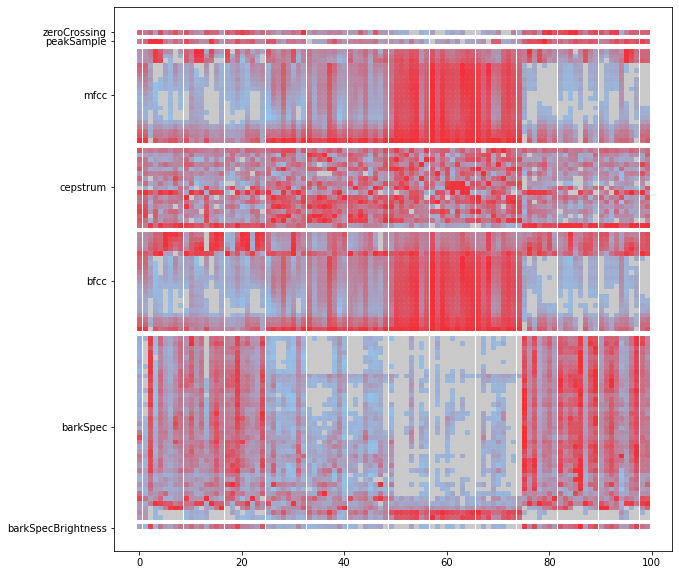

In [28]:
# %matplotlib qt
%matplotlib inline 


def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='#99B6DB' #blue
c2='#F42F37' #green
zero_color = '#C9C9C9'
s = 16

zero_threshold = 0.1
logscaled = False
spacing = 1

dataline = data[0]

def plot_data(data, header, zero_threshold, min_color, max_color, zero_color,log_scale, ax, space_between_features = True):
    def get_spaced_y(header):
        res_spaced = []
        res_ticks_pos = []
        res_ticks_names = []
        counter = 0
        last_prefix = header[0].split('_')[0]
        startblock = 0
        for idx,h in enumerate(header):
            if h.split('_')[0] != last_prefix:
                res_ticks_pos.append(((counter-startblock)/2 + startblock))
                res_ticks_names.append(last_prefix)
                startblock = counter+2
                counter+=1
            counter+=1
            res_spaced.append(counter)
            last_prefix = h.split('_')[0]
        res_ticks_pos.append(((counter-startblock)/2 + startblock))
        res_ticks_names.append(last_prefix)
        return res_spaced, res_ticks_pos, res_ticks_names

    def to_color (value, min, max, zero_threshold, min_color, max_color, zero_color,log_scale=False):
        if value < zero_threshold:
            return zero_color
        
        newvalue = (value - min) / (max - min)
        newvalue = (newvalue - zero_threshold) / (1 - zero_threshold)

        if log_scale:
            # print('Going log scale')
            newvalue = np.log(1+newvalue)/np.log(1+1)

        return colorFader(min_color,max_color,mix=newvalue)

    for dl_idx, dataline in enumerate(data):
        # dataline = dataline/max(dataline)
        x_axis = [dl_idx*spacing]*len(dataline)
        if space_between_features:
            y_axis, y_ticks_pos, y_ticks_names = get_spaced_y(header)
            ax.set_yticks(y_ticks_pos)
            ax.set_yticklabels(y_ticks_names)
        else:
            y_axis = list(range(len(dataline)))
        ax.scatter(x_axis,y_axis,c=[to_color(e,min(dataline),max(dataline),zero_threshold,c1,c2,zero_color,log_scale=log_scale) for e in dataline],s=s,marker='s')


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plot_data(data, header, zero_threshold, c1, c2, zero_color, logscaled, ax)
# fig.show()

In [29]:
# Learn scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(dataset_features.to_numpy())


MinMaxScaler()

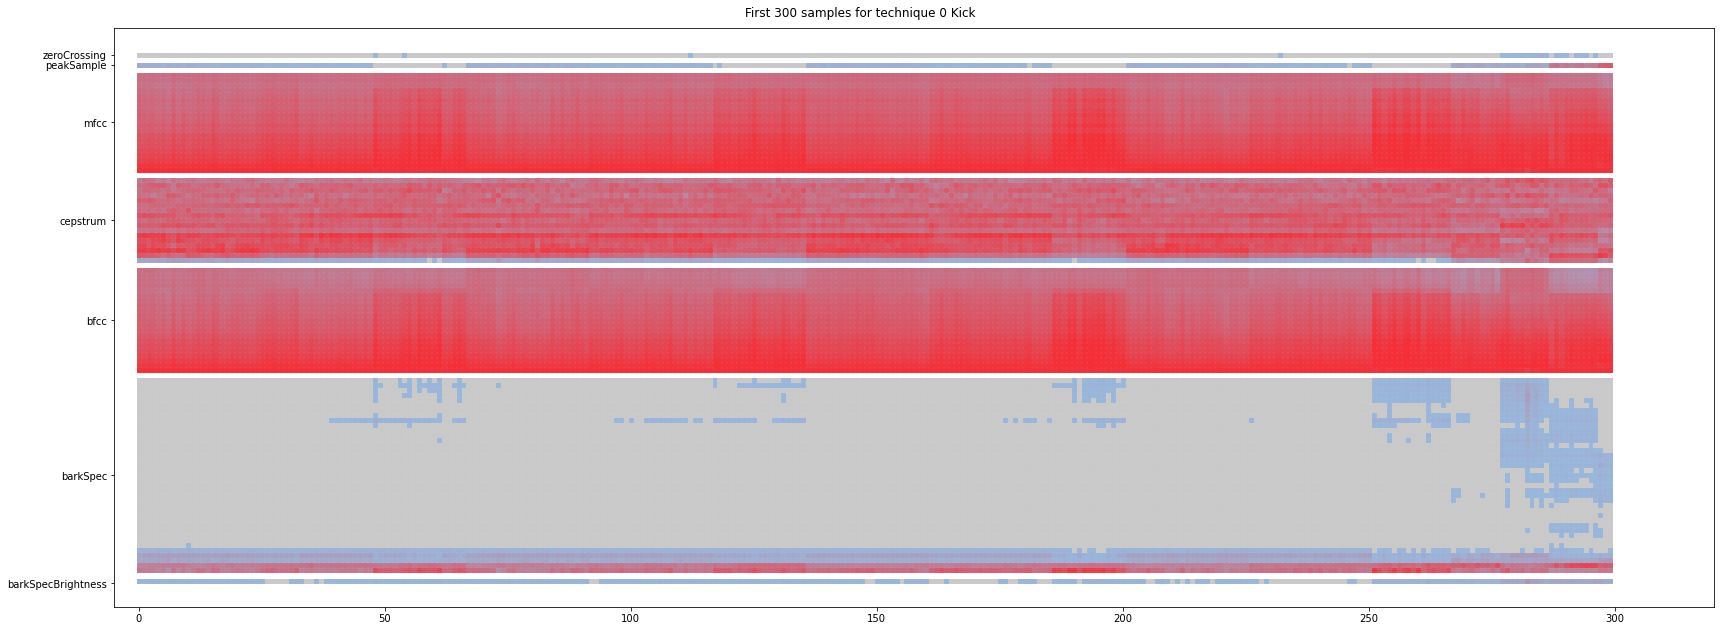

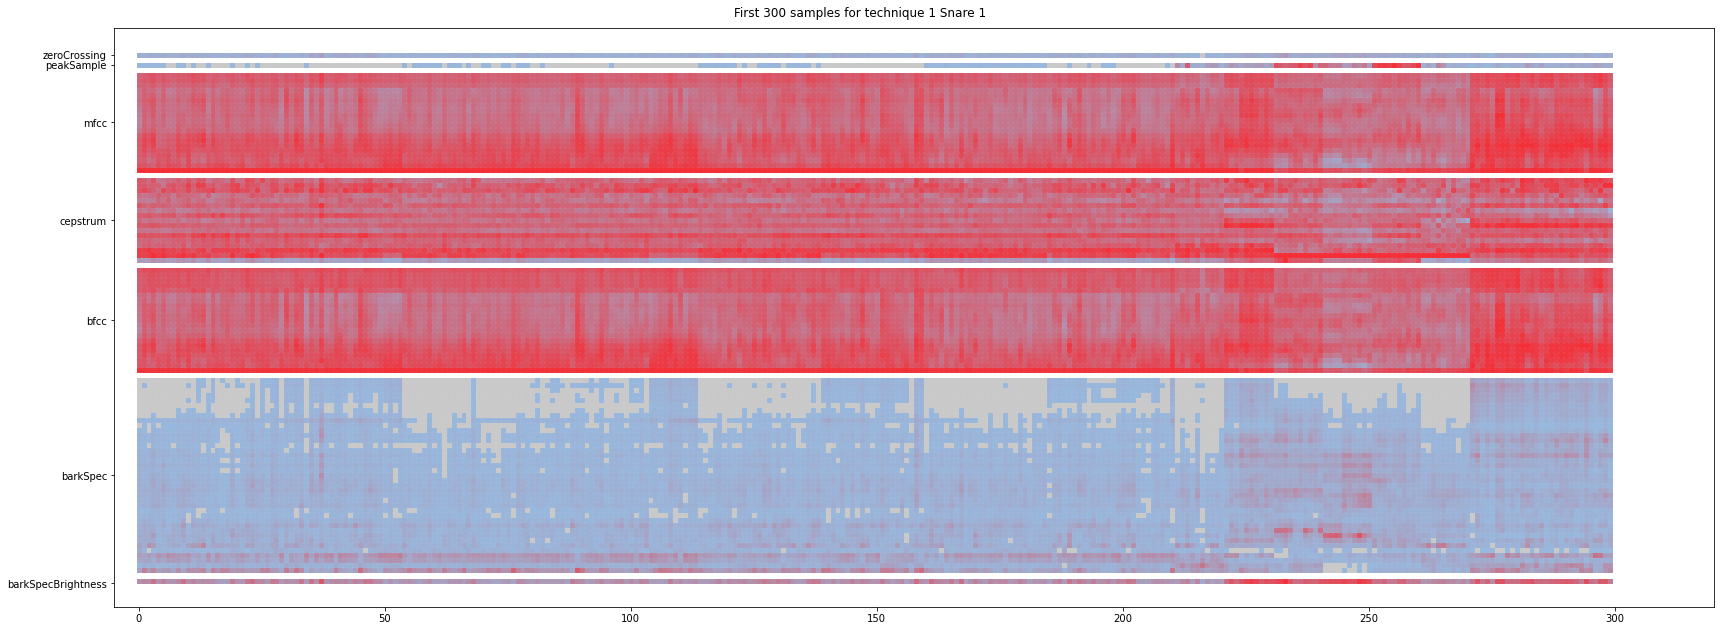

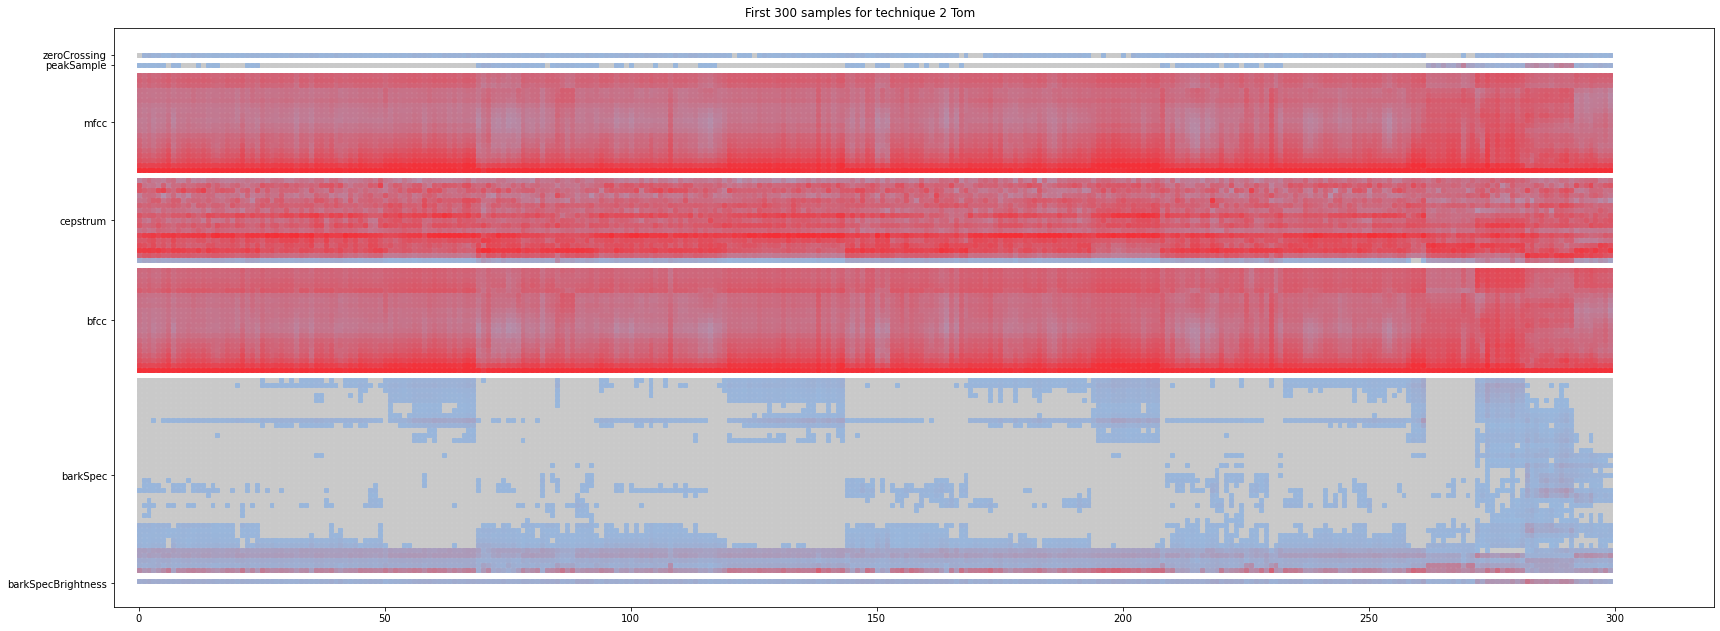

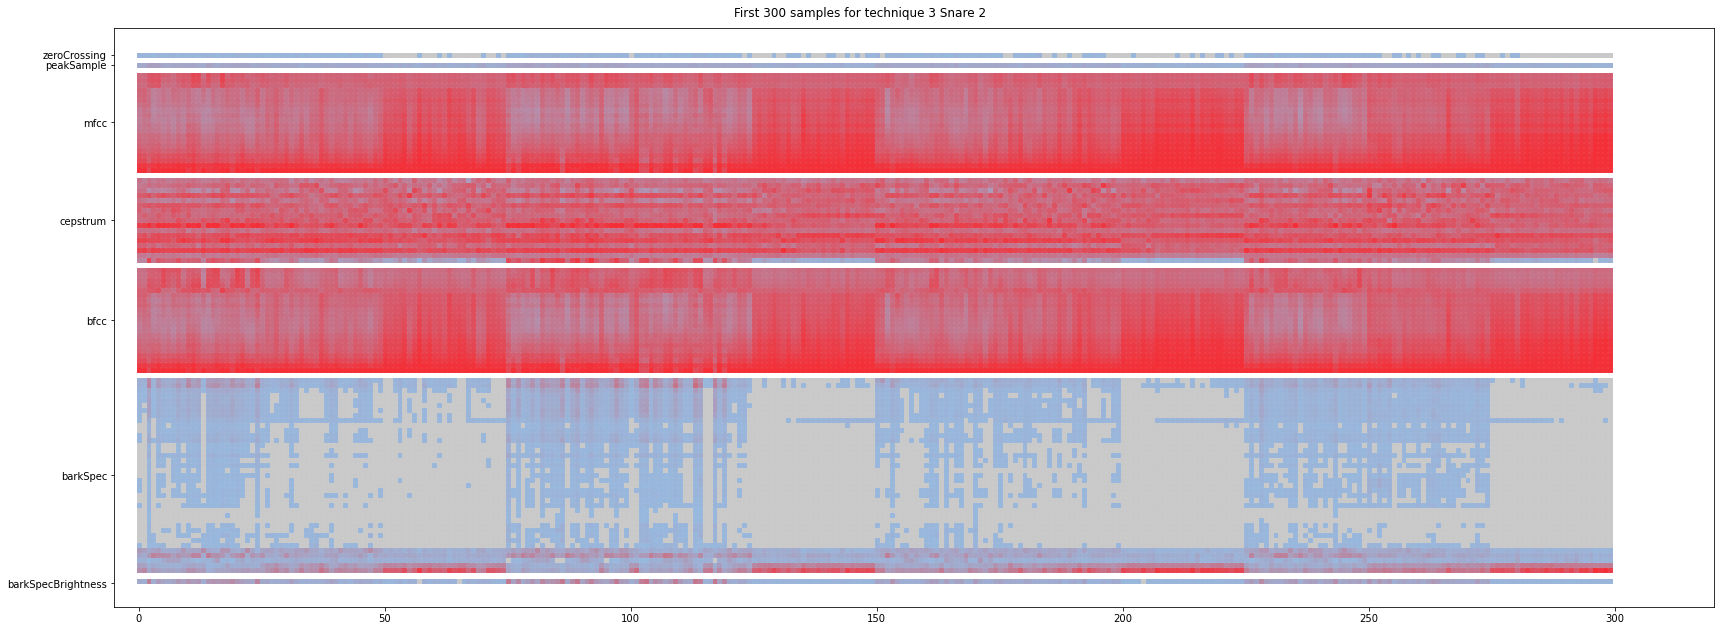

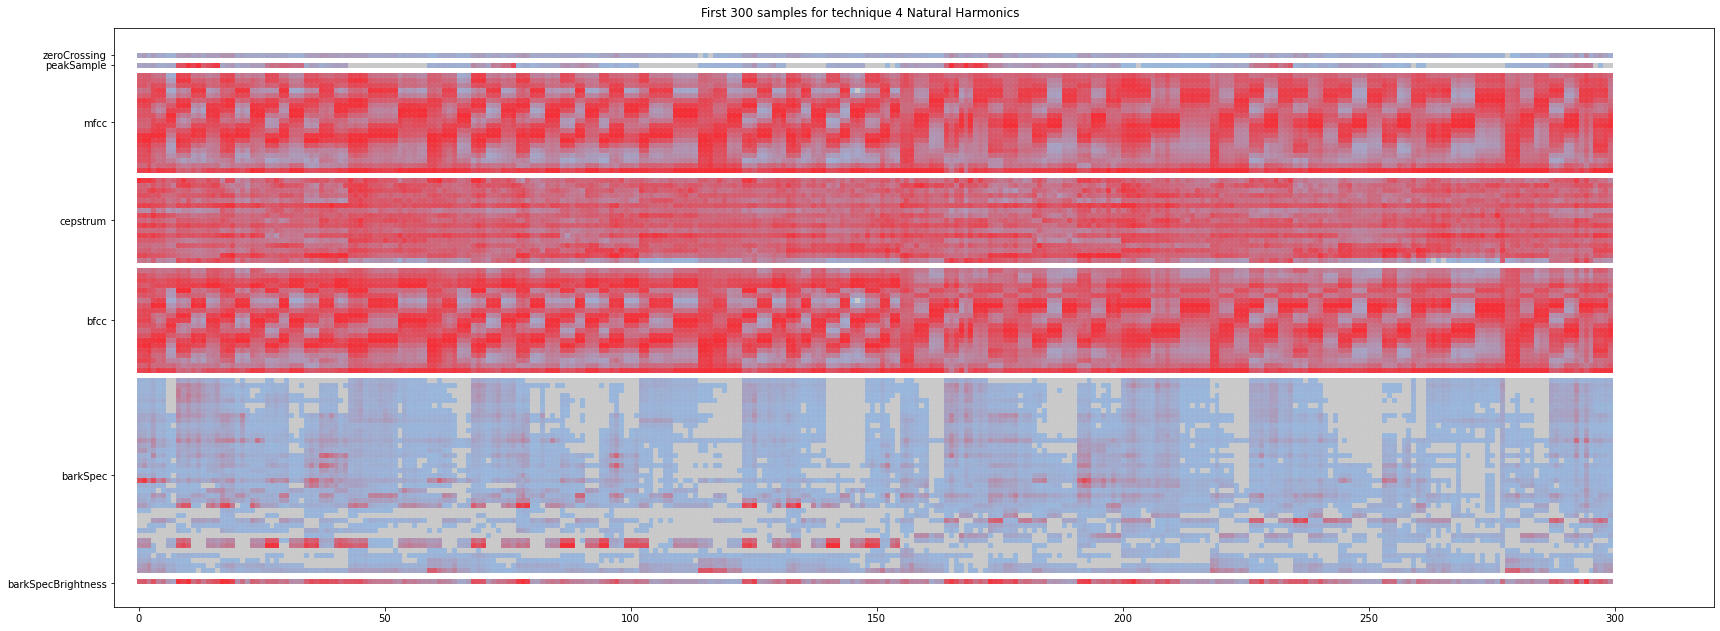

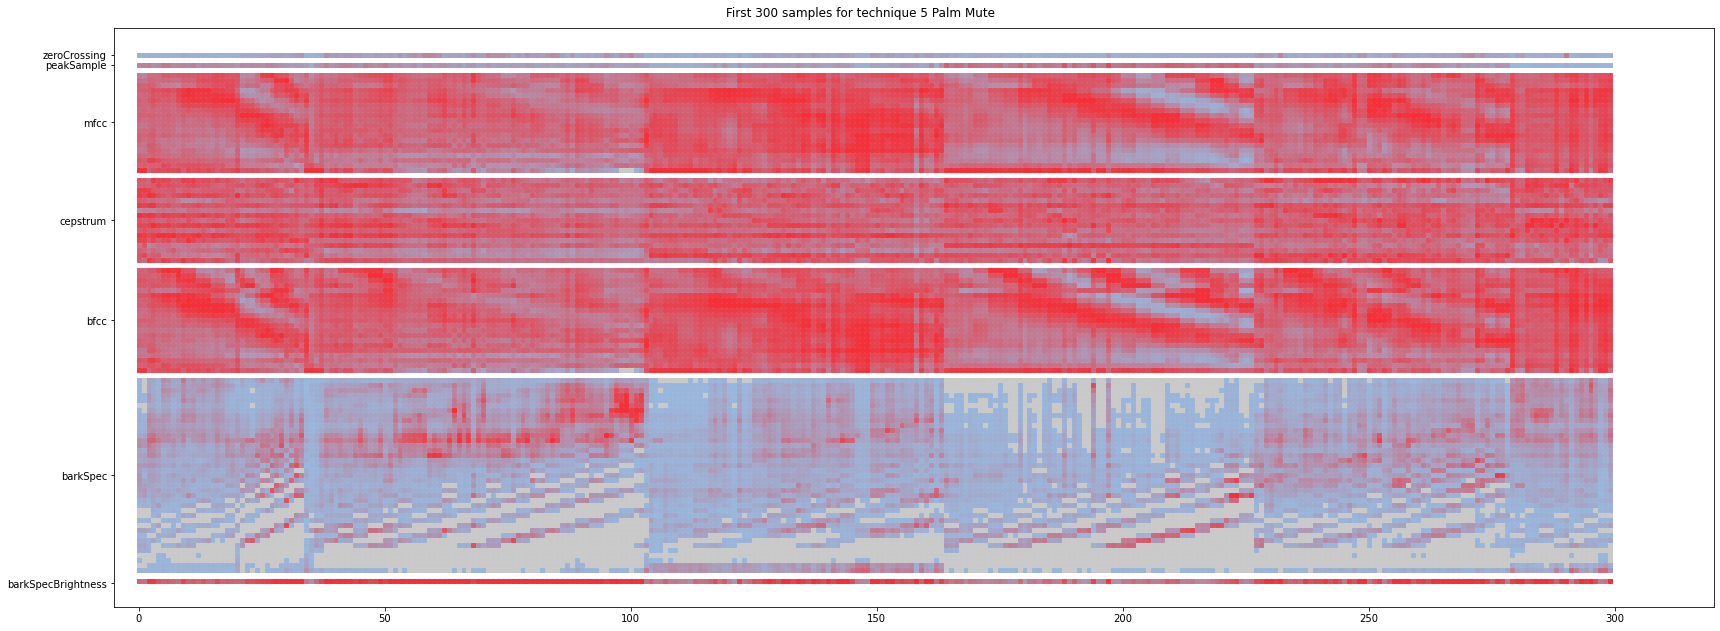

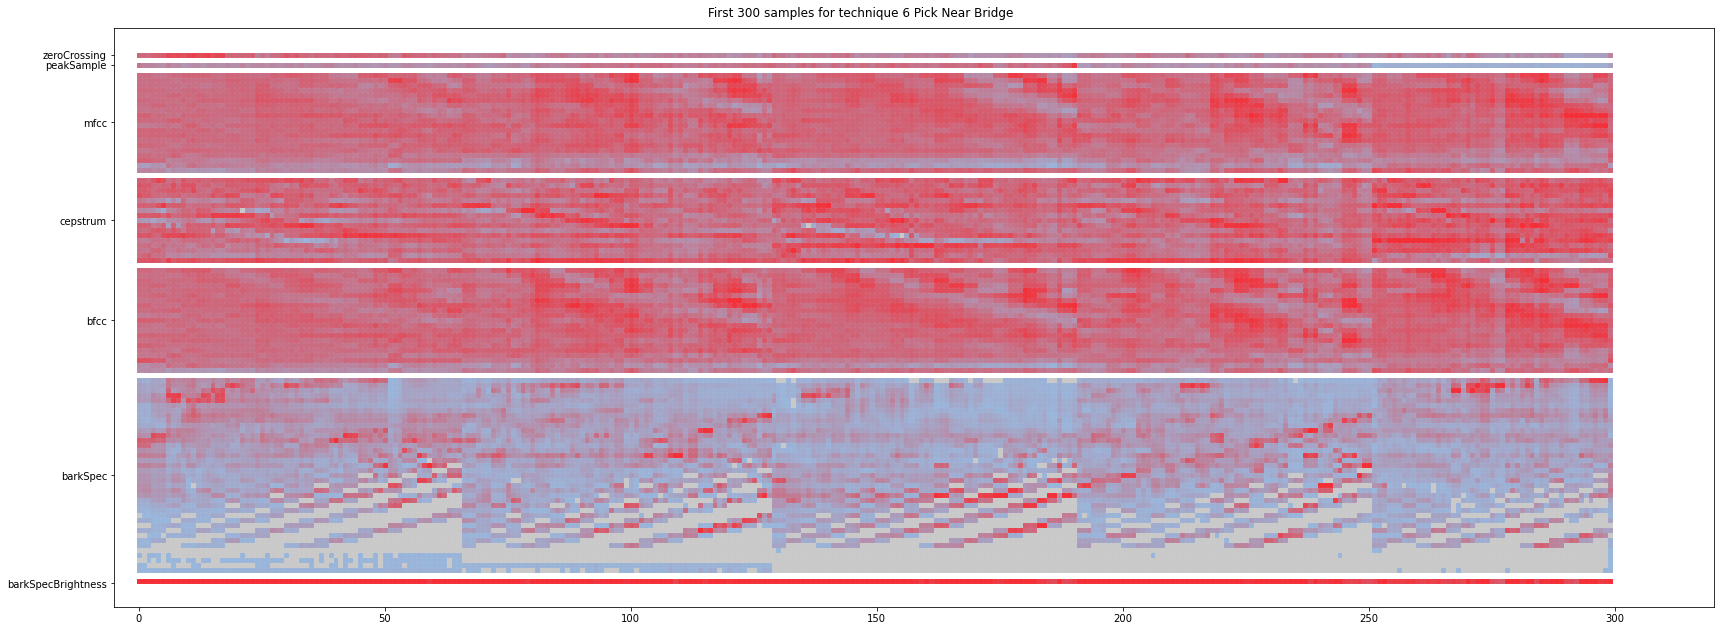

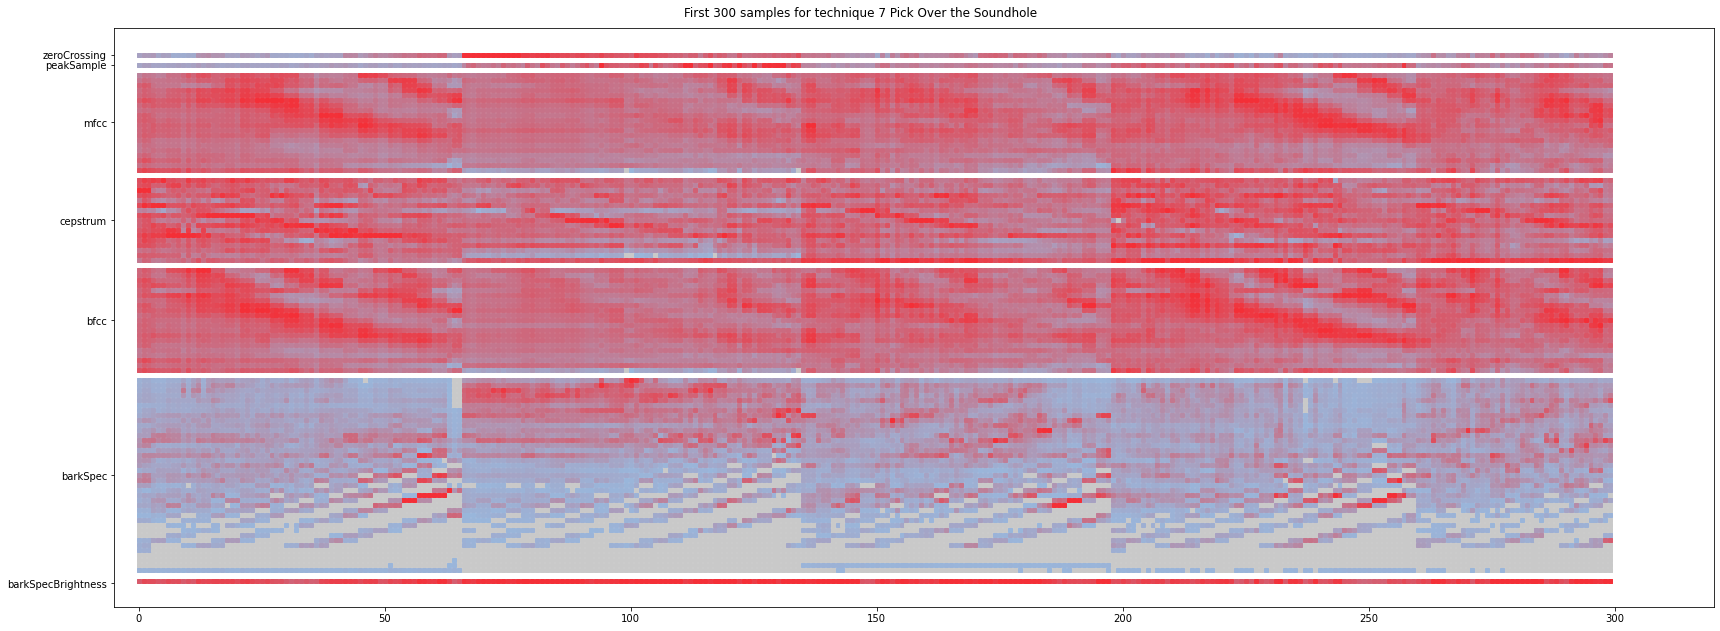

In [30]:
c1='#99B6DB' #blue
c2='#F42F37' #green
zero_color = '#C9C9C9'
s = 16

zero_threshold = 0.02
logscaled = False
spacing = 1

# how many samples to plot
samples_to_plot = 300


for technique in sorted(dataset_labels.unique()):
    # print(technique)
    features = dataset_features[dataset_labels==technique]
    # print(features.shape)

    data = features.iloc[range(samples_to_plot)].to_numpy()
    # data = features.sample(n=samples_to_plot).to_numpy()

    data = scaler.transform(data)


    fig = plt.figure(figsize=(24,8.9), tight_layout=True)
    ax = fig.add_subplot(111)
    ax.set_xlim(-5,320)
    fig.suptitle('First '+str(samples_to_plot)+' samples for technique '+str(technique)+' '+CLASSES_DESC[technique])
    plot_data(data, header, zero_threshold, c1, c2, zero_color, False, ax)

    fig.savefig('first_'+str(samples_to_plot)+'_samples_for_technique_'+str(technique)+'_'+CLASSES_DESC[technique]+'.png', dpi=300)

    # break

In [31]:
# def to_color (value, min, max, zero_threshold, min_color, max_color, zero_color,log_scale=False):
#     if value < zero_threshold:
#         return zero_color
    
#     newvalue = (value - min) / (max - min)
#     # print('value: ',value,' min: ',min,' max: ',max)
#     # print('newvalue: ',newvalue)
#     newvalue = (newvalue - zero_threshold) / (1 - zero_threshold)

#     if log_scale:
#         newvalue = np.log(1+newvalue)/np.log(1+1) 

#     # print('final newvalue',newvalue)

#     return colorFader(min_color,max_color,mix=newvalue)


# dd = list(range(120))

# fig = plt.figure(figsize=(30,1))
# ax = fig.add_subplot(111)
# ax.set_ylim(-1,2)
# zero_threshold = 0.0

# for idx,dato in enumerate(dd):
#     ax.scatter([dato],[0],
#                c=to_color(dato,min(dd),max(dd),zero_threshold,c1,c2,zero_color,log_scale=False),
#                s=200,
#                marker='s')

#     ax.scatter([dato],[1],
#                c=to_color(dato,min(dd),max(dd),zero_threshold,c1,c2,zero_color,log_scale=True),
#                s=200,
#                marker='s')


In [32]:
# # %matplotlib qt
# %matplotlib inline 


# for player in data_by_player:
#     X = data_by_player[player][0].to_numpy()

#     fig = plt.figure(figsize=figsize,)
#     ax1 = fig.add_subplot(131,projection='3d')
#     ax2 = fig.add_subplot(132)
#     ax3 = fig.add_subplot(133)

    
#         # fig.set_size_inches(30, 5)
#     # fig.suptitle(player, fontsize=16)


#     curtitle = "PCA from "+str(X.shape[1])+" features of guitarist '"+player+"'"
#     plt.gcf().canvas.manager.set_window_title(curtitle)

#     #set tight layout
#     fig.tight_layout()


#     # Compute PCA
#     from sklearn.decomposition import PCA

#     indexes = data_by_player[player][0].index
#     translate_indexes = {indexes[i]:i for i in range(len(indexes))}


#     # pca = PCA(n_components=3 if threed else 2)
#     pca = PCA(n_components=6)
#     X_pca = pca.fit_transform(X)
    

#     ax1.set_title(curtitle)

#     # ax3.scatter(X_pca[:,0],X_pca[:,1],c=colors)

#     features = data_by_player[player][0]
#     labels = data_by_player[player][1]

#     colors = [colorpalette[int(tech)] for tech in data_by_player[player][1].to_numpy()]
#     techniques = np.unique(labels.to_numpy()).tolist()
#     for technique_idx in techniques:
#         indexes_for_tech = labels[labels == technique_idx].index
#         translated_idxs = [translate_indexes[idx] for idx in indexes_for_tech]
#         pca_for_tech = X_pca[translated_idxs]

#         # print(pca_for_tech)
#         colors = [colorpalette[technique_idx]]*len(pca_for_tech)
#         #Set size of the points
#         s = 100
    
        
#         ax1.scatter(pca_for_tech[:,0],pca_for_tech[:,1],pca_for_tech[:,2],c=colors, alpha=alpha3d, s=s)
#         ax1.set_xlabel('PC1')
#         ax1.set_ylabel('PC2')
#         ax1.set_zlabel('PC3')

#         ax2.scatter(pca_for_tech[:,0],pca_for_tech[:,1],c=colors, alpha=alpha2d, s=s)
#         ax2.set_xlabel('PC1')
#         ax2.set_ylabel('PC2')

#         #set tight layout
#         fig.tight_layout()

        
#     ax1.legend([v for k,v in CLASSES_DESC.items()])


#     PC_values = np.arange(pca.n_components_) + 1
#     # ax.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
#     ax3.bar(PC_values, pca.explained_variance_ratio_, alpha=0.5, align='center', color='blue')
#     ax3.set_title('Scree Plot')
#     ax3.set_xlabel('Principal Component')
#     ax3.set_ylabel('Variance Explained')
#     plt.gcf().canvas.manager.set_window_title(' Scree Plot for '+curtitle)

#     # plt.show()
#     plt.savefig('PCA_'+player+'.png', dpi=300, bbox_inches='tight')

In [33]:
# %matplotlib qt
# # %matplotlib inline 

# side = 10
# figsize = (side*3,side)
# alpha3d = .7
# alpha2d = .4


# colorpalette = ["#0c090d","#ec5b81","#f15946","#f9c22e","#53b3cb","#5bc0eb","#cfcfea","#f7e1d7"]
# # colorpalette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# # colorpalette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17', '#666666']



# fig = plt.figure(figsize=figsize,)
# ax1 = fig.add_subplot(131,projection='3d')
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)


# curtitle = "PCA from "+str(X.shape[1])+" features for all the "+str(len(players))+" guitarists"
# plt.gcf().canvas.manager.set_window_title(curtitle)

# #set tight layout
# fig.tight_layout()


# # Compute PCA
# from sklearn.decomposition import PCA

# features = dataset_features
# labels = dataset_labels


# X = features.to_numpy()
# # indexes = data_by_player[player][0].index
# # translate_indexes = {indexes[i]:i for i in range(len(indexes))}


# # pca = PCA(n_components=3 if threed else 2)
# pca = PCA(n_components=6)
# X_pca = pca.fit_transform(X)


# ax1.set_title(curtitle)


# for technique_idx in np.unique(labels.to_numpy()).tolist():
#     indexes_for_tech = labels[labels == technique_idx].index
#     # translated_idxs = [translate_indexes[idx] for idx in indexes_for_tech]
#     translated_idxs = indexes_for_tech
#     pca_for_tech = X_pca[translated_idxs]

#     # print(pca_for_tech)
#     colors = [colorpalette[technique_idx]]*len(pca_for_tech)
#     #Set size of the points
#     s = 100

    
#     ax1.scatter(pca_for_tech[:,0],pca_for_tech[:,1],pca_for_tech[:,2],c=colors, alpha=alpha3d, s=s)
#     ax1.set_xlabel('PC1')
#     ax1.set_ylabel('PC2')
#     ax1.set_zlabel('PC3')

#     ax2.scatter(pca_for_tech[:,0],pca_for_tech[:,1],c=colors, alpha=alpha2d, s=s)
#     ax2.set_xlabel('PC1')
#     ax2.set_ylabel('PC2')

#     #set tight layout
#     fig.tight_layout()

    
# ax1.legend([v for k,v in CLASSES_DESC.items()])


# PC_values = np.arange(pca.n_components_) + 1
# # ax.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
# ax3.bar(PC_values, pca.explained_variance_ratio_, alpha=0.5, align='center', color='blue')
# ax3.set_title('Scree Plot')
# ax3.set_xlabel('Principal Component')
# ax3.set_ylabel('Variance Explained')
# plt.gcf().canvas.manager.set_window_title(' Scree Plot for '+curtitle)

# # plt.show()
# plt.savefig('PCA_allplayers.png', dpi=300, bbox_inches='tight')
